In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')

df

,x,y,z
0,42159.783600,0.000000,0.000000
1,39159.545914,15563.916303,266.913399
2,30572.229294,28909.053086,496.928223
3,17596.068412,38144.740319,671.356184
4,2068.446366,41949.706443,775.646554
...,...,...,...
995,38132.961517,21370.880108,-7532.333000
996,31399.515894,31233.289707,1828.575655
997,20906.077447,37238.565267,10967.804062
998,7871.245318,38575.122415,18731.818721


Now we want to predict X values (can change for Y, Z):

In [12]:
#Create a new dataframe with only the x column
data = df.filter(['x']) # CHANGE FOR Y,Z

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.8 ))

training_data_len

800

In [13]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [64]:
# Set roll-back window
window = 60 # default was set to 60 before

In [65]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(740, 60, 1)

In [66]:
#Create the testing data set
#Create a new array containing scaled values
test_data = scaled_data[training_data_len - window: , :]

#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window, len(test_data)):
    x_test.append(test_data[i-window:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(200, 60, 1)

## Model 1: Uni-Variate

Epoch 1/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0833: 1s - loss:  - ETA: 0s - loss: 0 - ETA: 0s - loss:
Epoch 2/10
47/47 [==============================] - 2s 43ms/step - loss: 9.2000e-04 - loss: 0.0 - ETA: 1s - loss - ETA: 0s - loss
Epoch 3/10
47/47 [==============================] - 2s 42ms/step - loss: 3.5476e-04
Epoch 4/10
47/47 [==============================] - 2s 42ms/step - loss: 3.0960e-04
Epoch 5/10
47/47 [==============================] - 2s 42ms/step - loss: 3.3103e-04: 1s -
Epoch 6/10
47/47 [==============================] - 2s 41ms/step - loss: 2.6927e-04
Epoch 7/10
47/47 [==============================] - 2s 41ms/step - loss: 2.1865e-04
Epoch 8/10
47/47 [==============================] - 2s 41ms/step - loss: 2.1768e-04
Epoch 9/10
47/47 [==============================] - 2s 41ms/step - loss: 1.7500e-04
Epoch 10/10
47/47 [==============================] - 2s 41ms/step - loss: 1.9380e-04


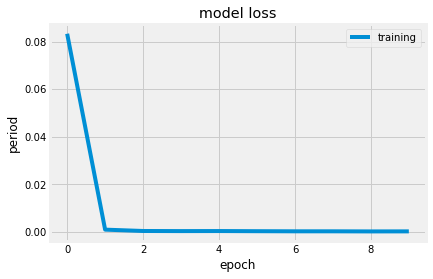

In [67]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1))) # input_shape = (60,1)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(x_train, y_train, batch_size=16, epochs=10)

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

In [68]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

878.2505556333433

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


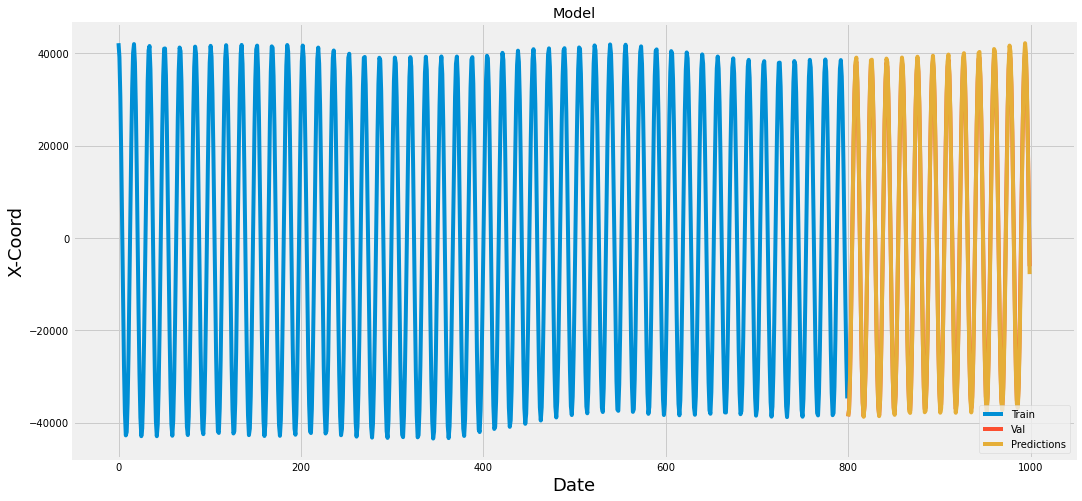

In [69]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('X-Coord', fontsize=18)
plt.plot(train['x'])
plt.plot(valid[['x', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Error plot:

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

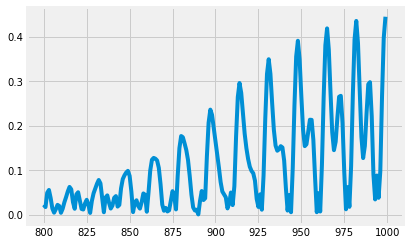

In [57]:
valid['Error']=abs(valid.Predictions-valid.x)/6738 # the normalization ct is taken as ISS semi-major axis
valid.Error.plot()

## Model 2: Multi-Variate

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

df.head()

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545914,15563.916303,266.913399,-1.142984,2.852848,0.048528
2,30572.229294,28909.053086,496.928223,-2.127756,2.228986,0.039518
3,17596.068412,38144.740319,671.356184,-2.813645,1.287415,0.027234
4,2068.446366,41949.706443,775.646554,-3.098444,0.161675,0.012698


In [165]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset) - look_back -1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 2])
    return np.array(dataX), np.array(dataY)

In [166]:
# load the dataset
dataset = df.values

# normalize the dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [167]:
# split into train and test sets
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# reshape into X=t and Y=t+1
look_back = 60
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 6))
testX = np.reshape(testX, (testX.shape[0],look_back, 6))

In [168]:
trainX.shape

(739, 60, 6)

In [169]:
testX.shape

(139, 60, 6)

Epoch 1/10
47/47 [==============================] - 2s 45ms/step - loss: 0.0420
Epoch 2/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0057
Epoch 3/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0040
Epoch 4/10
47/47 [==============================] - 2s 42ms/step - loss: 0.0015
Epoch 5/10
47/47 [==============================] - 2s 42ms/step - loss: 1.9248e-04
Epoch 6/10
47/47 [==============================] - 2s 40ms/step - loss: 1.4763e-04
Epoch 7/10
47/47 [==============================] - 2s 41ms/step - loss: 1.2413e-04
Epoch 8/10
47/47 [==============================] - 2s 41ms/step - loss: 1.1233e-04
Epoch 9/10
47/47 [==============================] - 2s 41ms/step - loss: 7.5040e-05
Epoch 10/10
47/47 [==============================] - 2s 41ms/step - loss: 5.9050e-05:


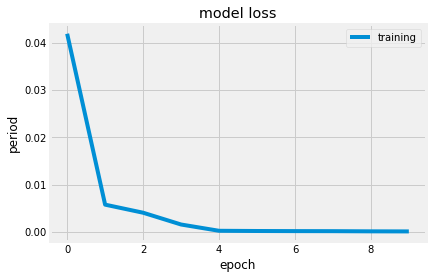

In [170]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (look_back, 6)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(trainX, trainY, batch_size=16, epochs=10)

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

In [171]:
# Get the models predicted price values 
predictions = model.predict(testX)
#predictions = scaler.inverse_transform(predictions)

# Get something which has as many features as dataset
predict_ext = np.zeros((len(predictions), 6))
# Put the predictions there
predict_ext[:,2] = predictions[:,0]
# Inverse transform it and select the 3rd column.
predictions = scaler.inverse_transform(predict_ext)[:,2]


testY_extended = np.zeros((len(testY),6))
testY_extended[:,2]=testY
testY=scaler.inverse_transform(testY_extended)[:,2]

In [172]:
# RMSE
rmse = np.sqrt(np.mean(((predictions - testY) ** 2)))
rmse

413.31486729192704

In [153]:
# Plot the data
train = df[:train_size]
test = df[train_size:]
test

,x,y,z,x_vv,y_vv,z_vv
800,-38640.279625,-2764.935183,17604.980941,-0.242379,-2.869481,-1.032661
801,-37222.004154,-17134.306183,11135.984105,0.783117,-2.603604,-1.431914
802,-30699.416577,-29154.049729,3087.546466,1.701144,-1.974296,-1.633559
803,-19981.800403,-37148.488205,-5420.909441,2.380643,-1.071344,-1.607049
804,-6568.003292,-40025.406603,-13203.492438,2.729043,-0.025797,-1.357603
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [179]:
dataa = {'testY': testY, 'predictions': predictions}
dff = pd.DataFrame.from_dict(dataa)

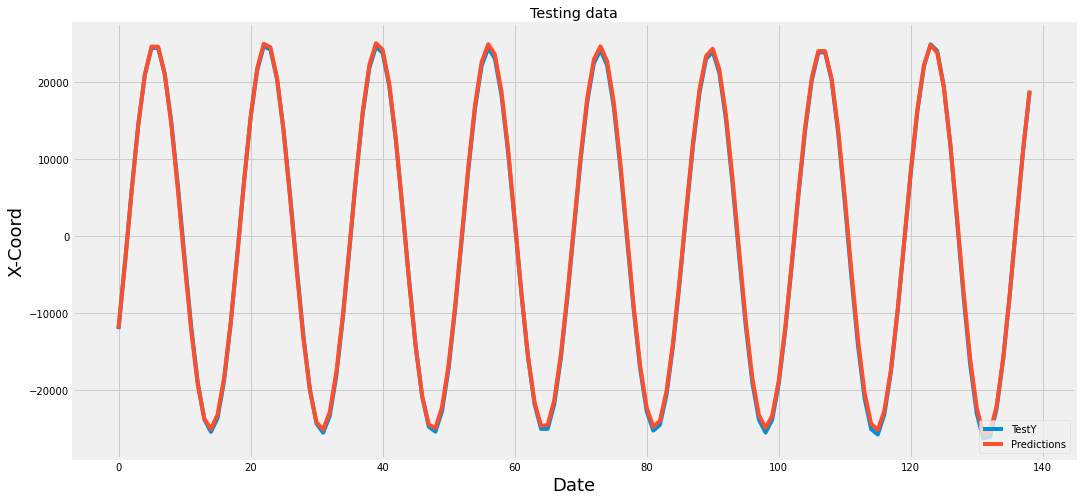

In [180]:
plt.figure(figsize=(16,8))
plt.title('Testing data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('X-Coord', fontsize=18)
plt.plot(dff.testY)
plt.plot(dff.predictions)
plt.legend(['TestY', 'Predictions'], loc='lower right')
plt.show()

In [154]:
predictions

array([-11436.00149967,  -2709.84119596,   6580.7301307 ,  15129.79606441,
        21657.19329944,  25151.12999708,  25062.33352941,  21400.04031473,
        14721.95437631,   6032.6040506 ,  -3388.71336618, -12203.62287295,
       -19232.38853575, -23615.57043775, -24879.64500592, -22923.07138688,
       -17979.9421082 , -10604.37013151,  -1668.77579647,   7673.86892574,
        16113.12851327,  22388.41025551,  25523.15426384,  25013.44058427,
        20923.6740998 ,  13874.33537491,   4930.8996897 ,  -4583.35060986,
       -13316.30176981, -20107.78807009, -24141.63462075, -24996.98414825,
       -22626.01259265, -17316.49954398,  -9675.14803013,   -617.85191552,
         8681.26363169,  16920.81654819,  22874.11046727,  25610.26750177,
        24674.80037409,  20185.58090628,  12820.96288257,   3700.55022655,
        -5817.16716037, -14377.01475997, -20849.32395633, -24469.67136022,
       -24874.79619125, -22073.03884138, -16407.67745526,  -8539.51530737,
          572.49644658,  